In [1]:
import yaml
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from SimBMVtool import SimBMVtool as sim

path_config = './config_simu.yaml'

paths: {'irf': '/fefs/aswg/workspace/marie-sophie.carrasco/projects/analysis/simulation/ressources/size_200_leakage_0.2_gammaness_eff60_ebins_5pdec_diffuse', 'gammapy_catalog': '/fefs/aswg/workspace/marie-sophie.carrasco/projects/dev-github/gammapy-extra/datasets/catalogs/gammacat/gammacat.fits.gz', 'output_dir': './outputs', 'simulated_obs_dir': './outputs/datasets', 'save_name_obs': 'gaussian_background', 'save_name_suffix': '20_mn_consecutive_runs'}
simulation: {'n_run': 2, 'livetime': 1200, 'single_pointing': False, 'obs_collection_type': 'n_run_obs_per_wobble', 't_ref': '2024-10-05 23:00:00', 'delay': 1200, 'time_oversampling': 100, 'fov_rotation_error_limit': 1, 'e_min': 0.5, 'e_max': 10}
wobble_1: {'run': 11895, 'seed': 4, 'obs_id': '1'}
wobble_2: {'run': 11896, 'seed': 42, 'obs_id': '2'}
source: {'catalog_name': 'Crab nebula', 'flux_to_0': False, 'exclusion_region': {'shape': 'noexclusion', 'radius': 0}}
background: {'spectral_model': {'model': 'PowerLawNormSpectralModel', 'fac

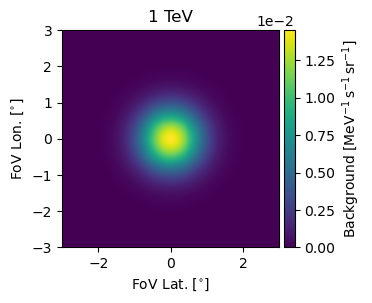

0
EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (25, 6)
  ndim  : 2
  unit  : m2
  dtype : >f8

EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (25, 30, 6)
  ndim  : 3
  unit  : 
  dtype : >f8

PSF3D
-----

  axes  : ['energy_true', 'offset', 'rad']
  shape : (25, 6, 100)
  ndim  : 3
  unit  : 1 / sr
  dtype : >f8

Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (30, 440, 440)
  ndim  : 3
  unit  : 1 / (MeV s sr)
  dtype : float64

0


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


1


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


2


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


3


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


4


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


5


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


6


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


7


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


8


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


9


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


10


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


11


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


12


1
0


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


1


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


2


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


3


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


4


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


5


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


6


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


7


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


8


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


9


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


10


11


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


12


0
EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (25, 6)
  ndim  : 2
  unit  : m2
  dtype : >f8

EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (25, 30, 6)
  ndim  : 3
  unit  : 
  dtype : >f8

PSF3D
-----

  axes  : ['energy_true', 'offset', 'rad']
  shape : (25, 6, 100)
  ndim  : 3
  unit  : 1 / sr
  dtype : >f8

Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (30, 440, 440)
  ndim  : 3
  unit  : 1 / (MeV s sr)
  dtype : float64

0


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


1


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


2


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


3


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


4


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


5


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


6


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


7


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


8


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


9


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


10


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


11


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


12


1
0


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


1


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


2


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


3


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


4


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


5


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


6


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


7


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


8


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


9


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


10


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


11


/fefs/aswg/workspace/marie-sophie.carrasco/miniconda3/envs/SimBMVtool/lib/python3.11/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(


12


INFO:gammapy.data.data_store:Observations selected: 4 out of 4.


Simulation dir: ./outputs/datasets/gaussian_background/n_run_obs_per_wobble_20_mn_consecutive_runs
Obs collection loading pattern: obs_*gaussian_background.fits
Available sources:    OBJECT  
----------
model-simu
4 available runs:  [1 2 3 4]
Total simulated livetime: 1.3 h


In [2]:
accmodel = sim.BaseSimBMVCreator()
accmodel.load_true_background_irfs(path_config) 

# If you want to get the gammapy BackgroundIRF without knowing the name of the variables
true = accmodel.get_background_irf(type='true',downsampled=False) 
true.plot_at_energy(["1 TeV"],figsize=(3,3))
plt.show()

do_simulation = True
if do_simulation: accmodel.do_simulation()
else: accmodel.load_observation_collection()

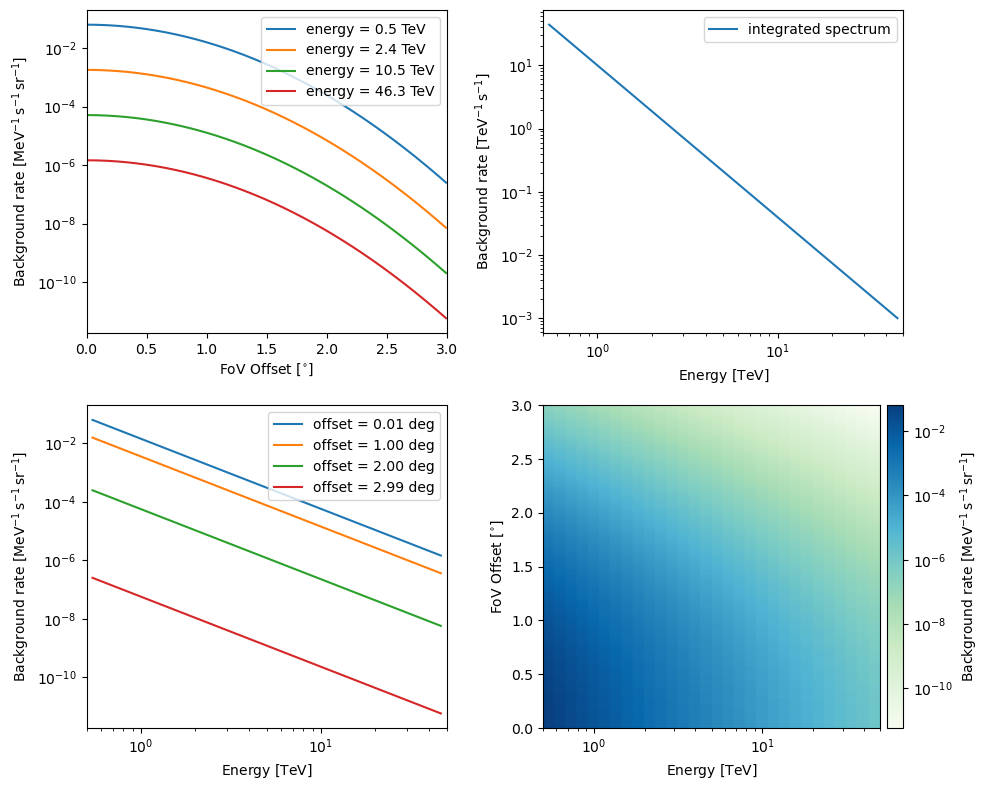

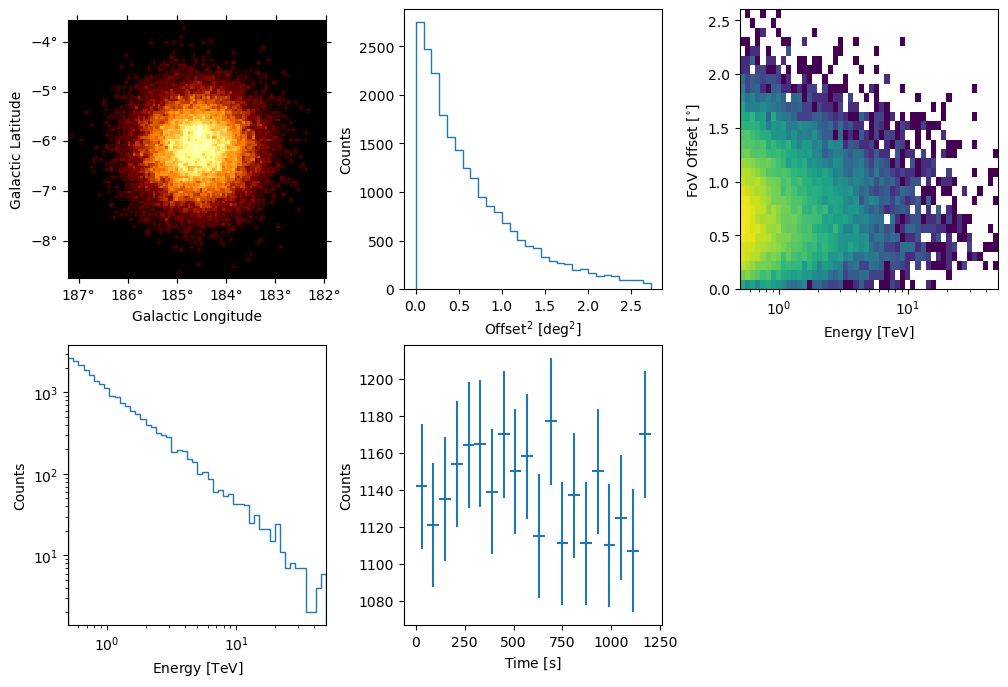

In [4]:
accmodel.obs_collection[1].bkg.peek()
accmodel.obs_collection[1].events.peek()